In [1]:
from threading import Thread
import numpy as np
import cv2
from __future__ import print_function
import glob
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from AntiInstagram import AntiInstagram
from collections import namedtuple

In [44]:
def bgrshow(bgr):
    imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
def imshow(img):
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.imshow(img)
    plt.show()

In [19]:
hsv_white1 =  np.array([0,0,150])
hsv_white2 =  np.array([180,60,255])
hsv_yellow1 = np.array([25,140,100])
hsv_yellow2 = np.array([45,255,255])
hsv_red1 =    np.array([0,140,100])
hsv_red2 =    np.array([15,255,255])
hsv_red3 =    np.array([165,140,100])
hsv_red4 =    np.array([180,255,255])

dilation_kernel_size = 3

ColorFilteredImage = namedtuple('ColorFilteredImage', 'patches edges')

def colorFilter(hsv, edges, color):
    # threshold colors in HSV space
    if color == 'white':
        bw = cv2.inRange(hsv, hsv_white1, hsv_white2)
    elif color == 'yellow':
        bw = cv2.inRange(hsv, hsv_yellow1, hsv_yellow2)
    elif color == 'red':
        bw1 = cv2.inRange(hsv, hsv_red1, hsv_red2)
        bw2 = cv2.inRange(hsv, hsv_red3, hsv_red4)
        bw = cv2.bitwise_or(bw1, bw2)
    # binary dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(dilation_kernel_size, dilation_kernel_size))

    # refine edge for certain color
    edge_color = cv2.bitwise_and(cv2.dilate(bw, kernel), edges)

    return ColorFilteredImage(bw, edge_color)

In [4]:
canny_thresholds = [80, 200]

def findEdge(img):
    edges = cv2.Canny(img, canny_thresholds[0], canny_thresholds[1], apertureSize = 3)
    return edges

In [67]:
def process(img):
    cbimage = ai.apply_color_balance(img, output_scale)
    hsv = cv2.cvtColor(cbimage, cv2.COLOR_BGR2HSV)
    edges = findEdge(hsv)
    return colorFilter(hsv, edges, 'red')

setup AI filter


[[ -3.58976759e-05  -2.34916931e-04  -1.37420153e-01]
 [  8.24753590e-04  -5.00225098e-06  -2.68559015e-01]
 [ -5.66450441e-05  -6.30011413e-03   1.00000000e+00]]


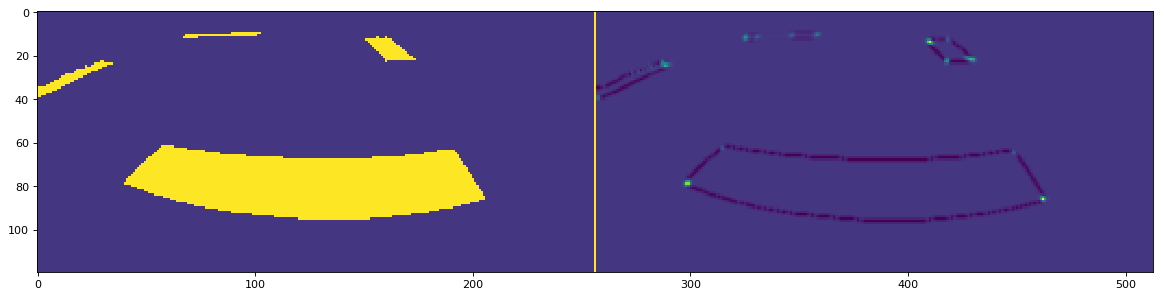

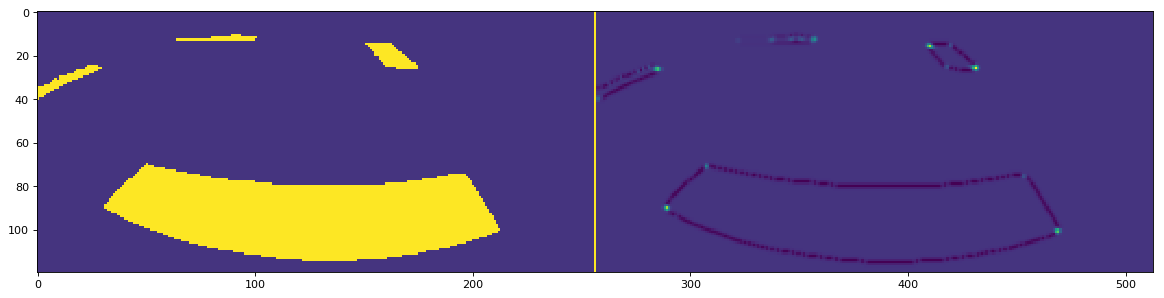

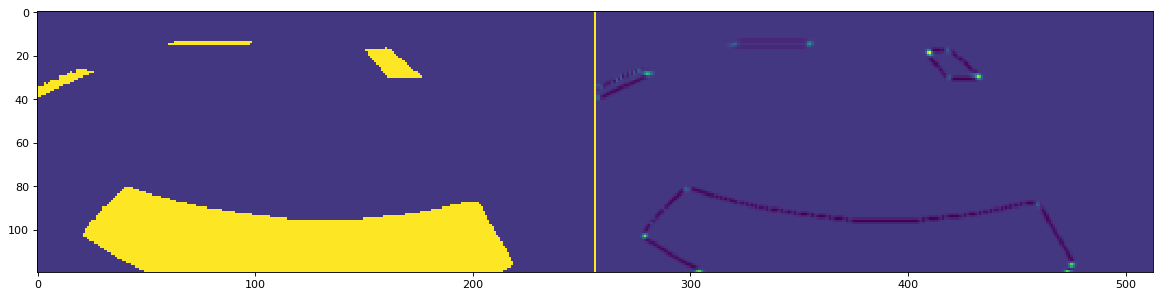

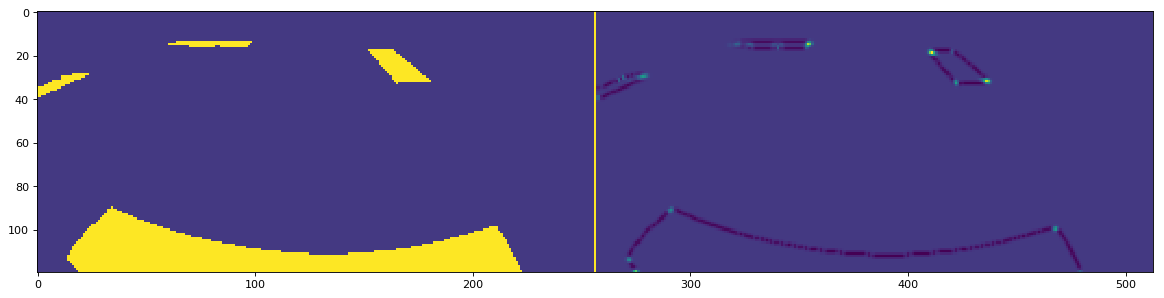

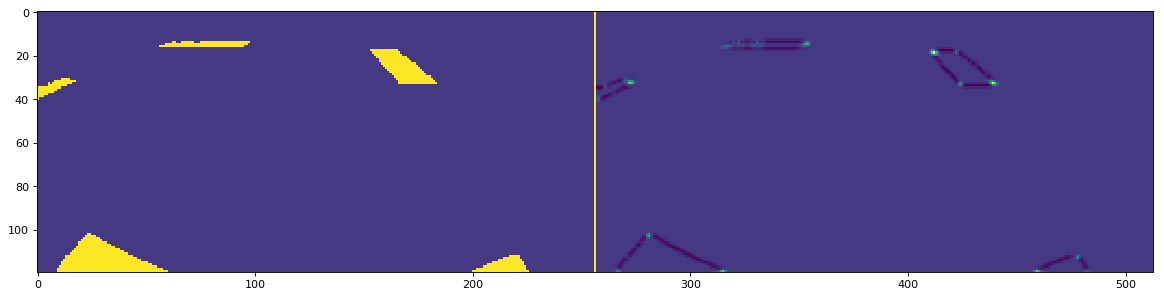

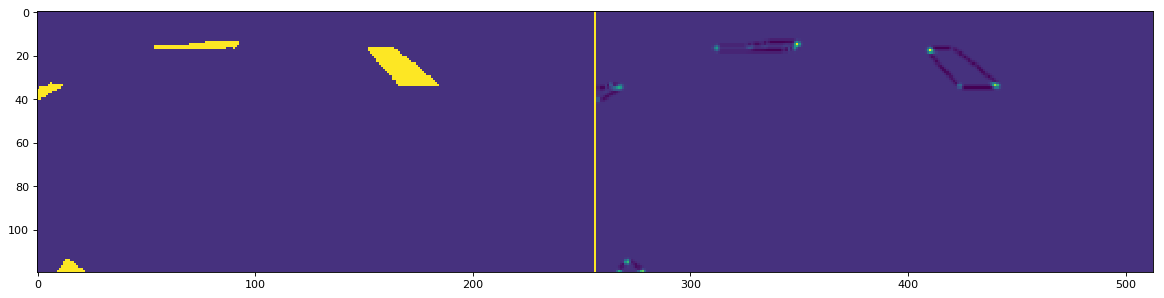

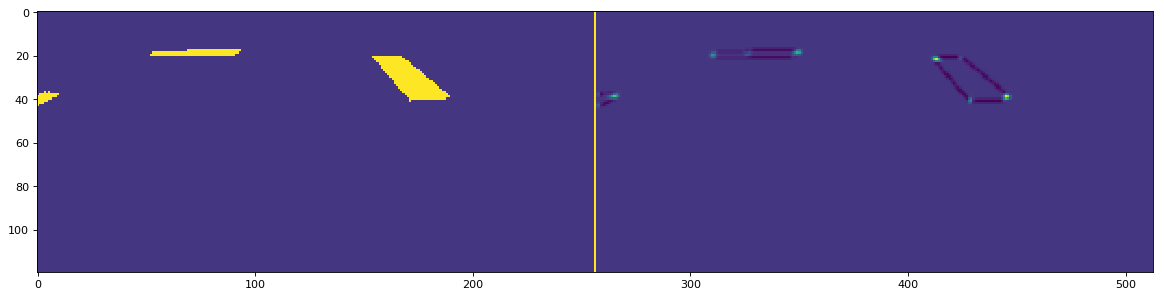

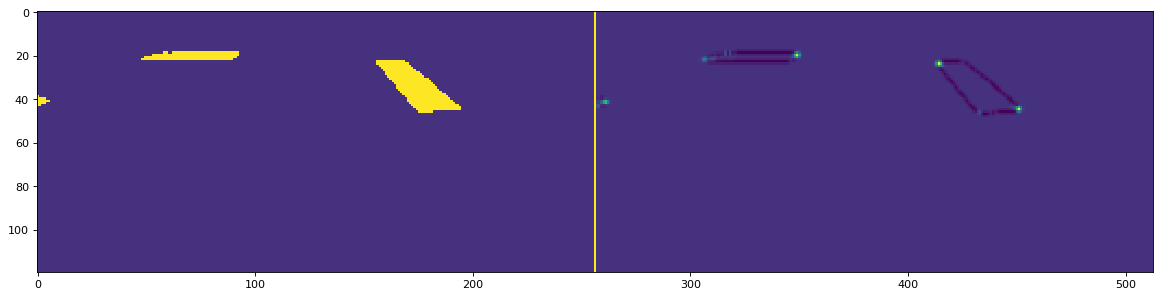

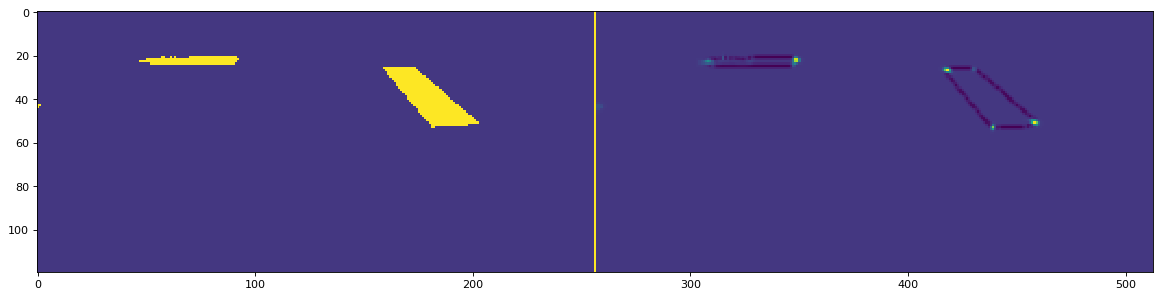

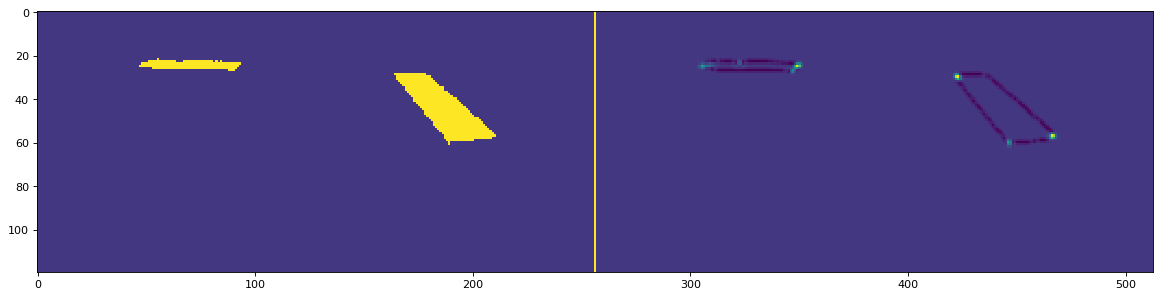

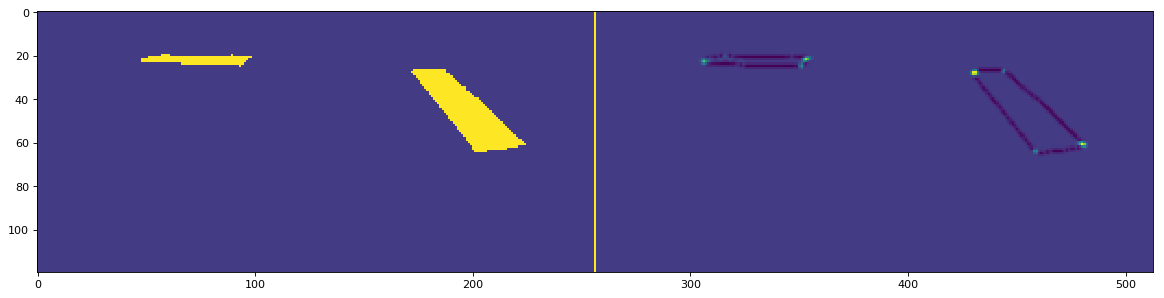

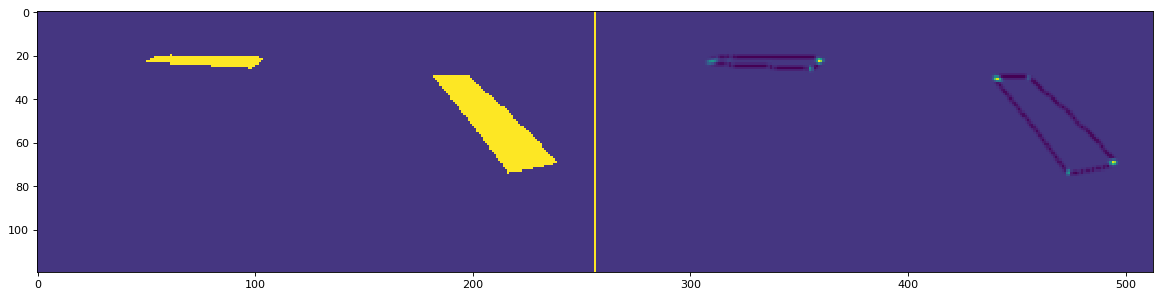

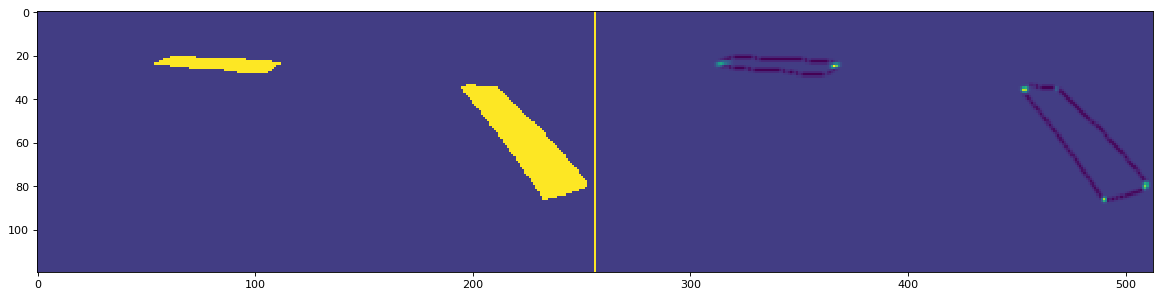

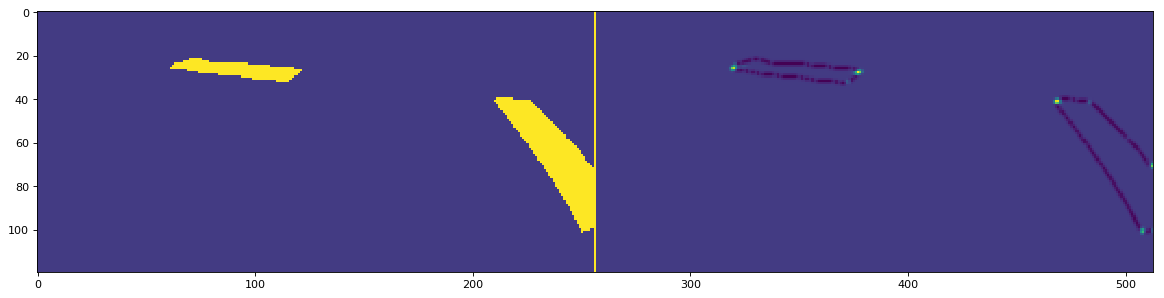

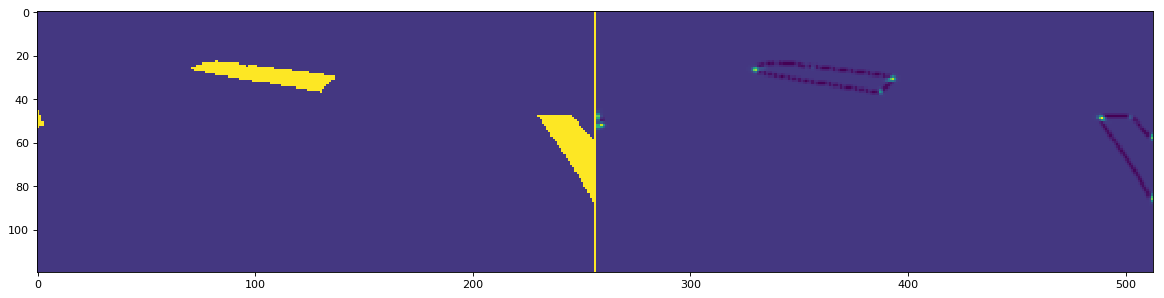

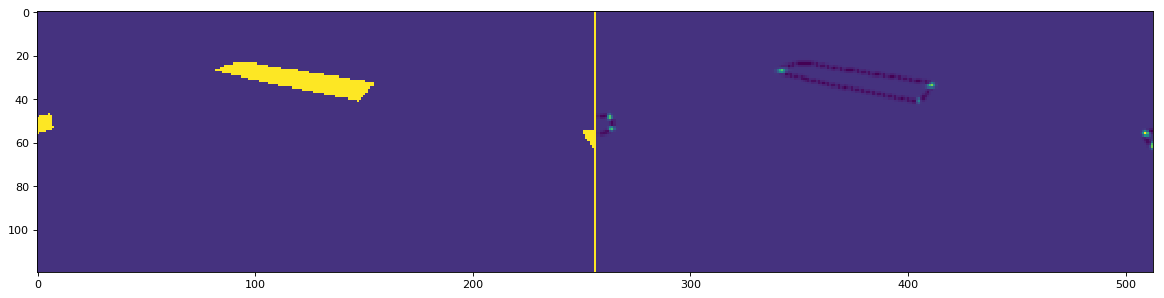

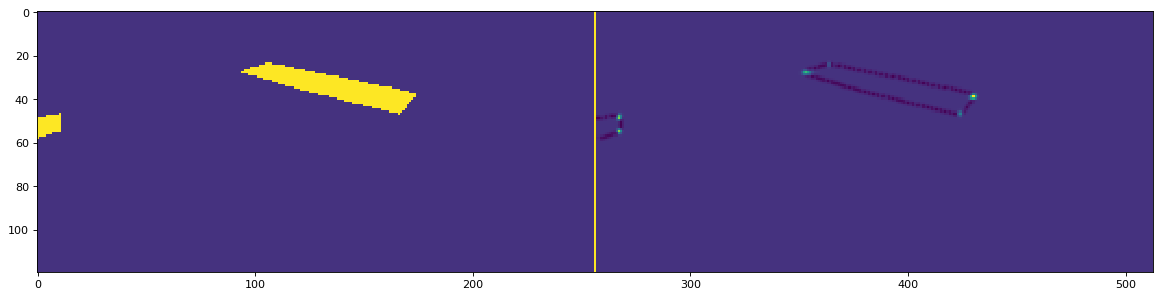

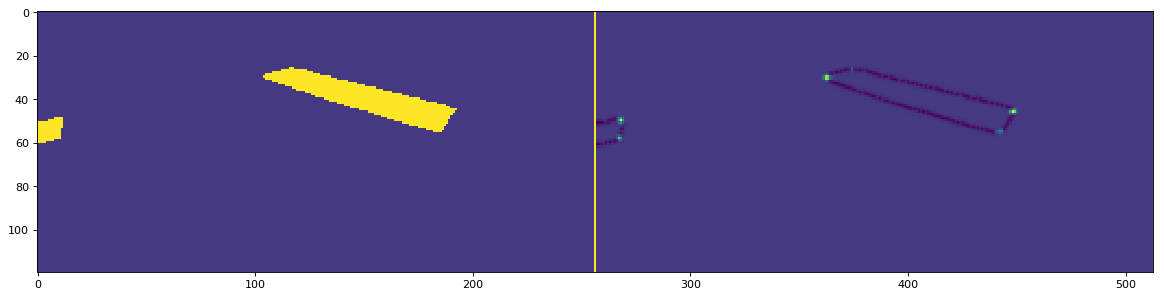

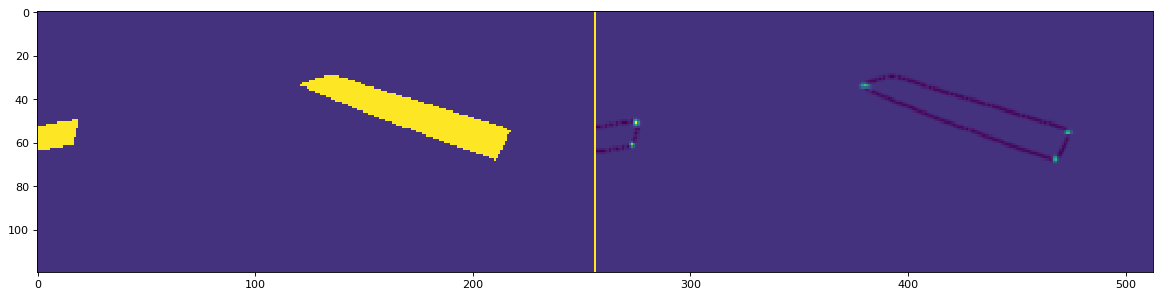

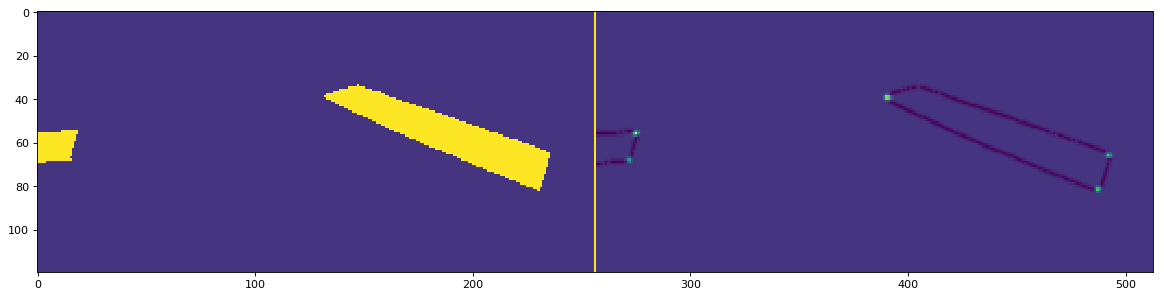

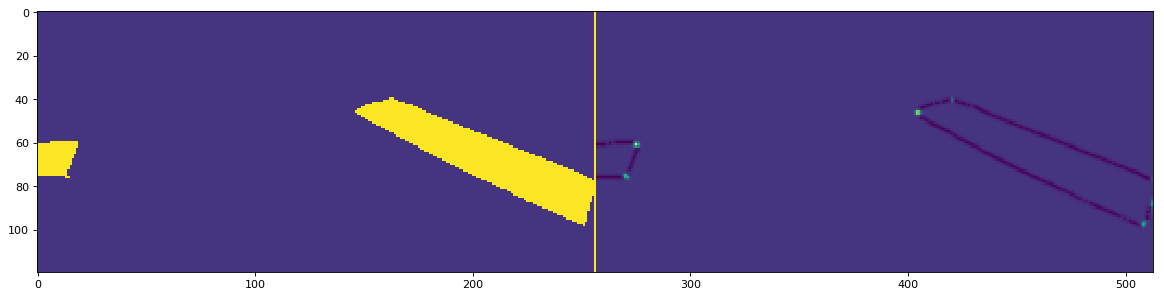

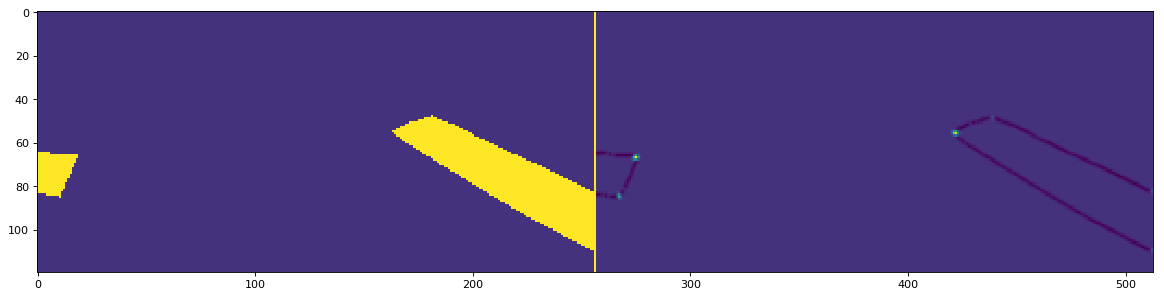

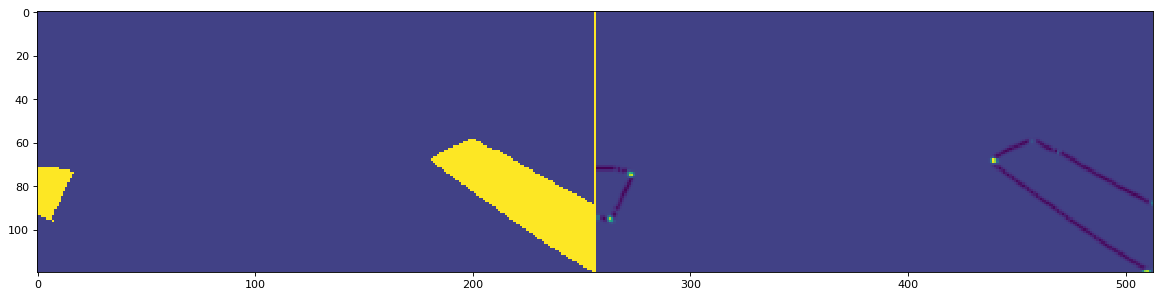

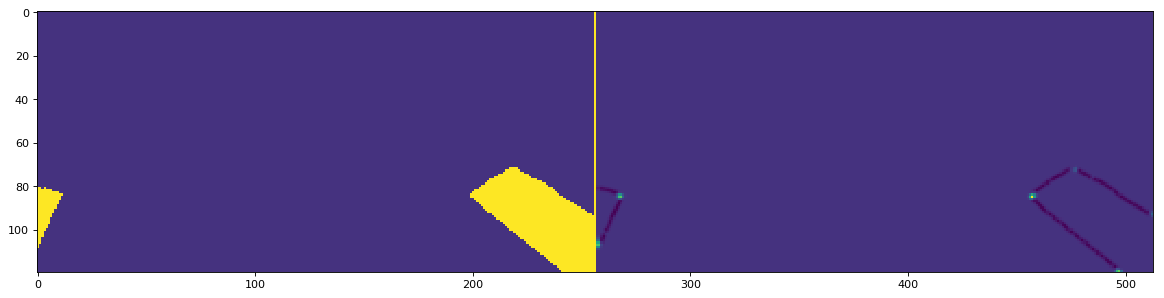

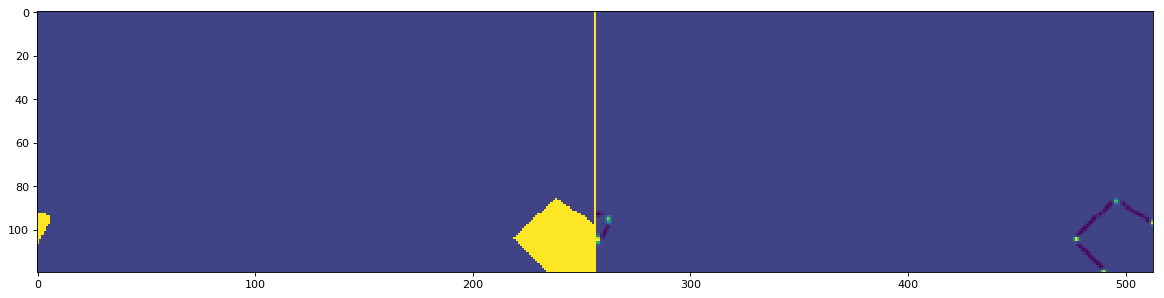

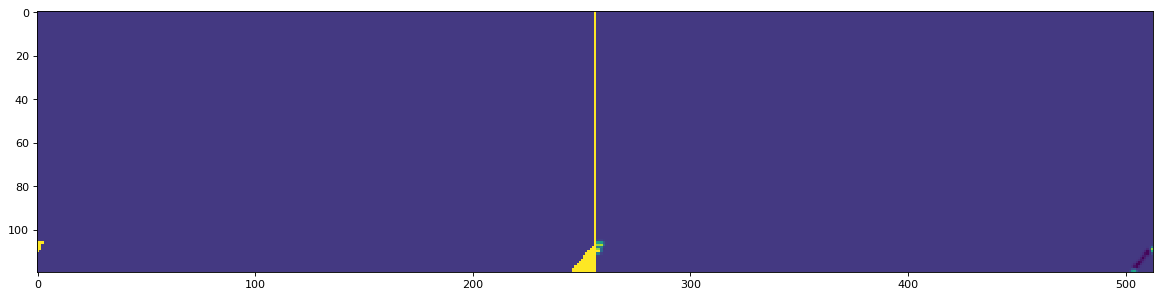

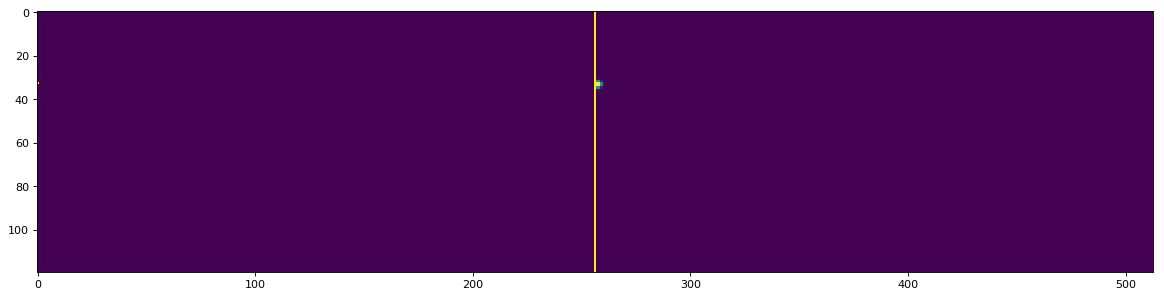

In [72]:
for i in range(len(compressed)):
    raw = compressed[i]
    red = process(raw)
    crns = cv2.cornerHarris(red.patches,2,7,0.01)
    cnrs = crns - np.min(crns)
    crns_max = np.max(crns)
    if crns_max == 0: continue
    crns = 255.0/crns_max*crns
    h,_ = np.shape(crns)
    divider = np.ones((h,np.floor(output_scale*3)))*255
    #imshow(red.patches)
    #imshow(red.edges)
    #bgrshow(raw)
    #print(red.edges)
    imshow(np.concatenate((red.patches, divider, crns),axis=1))

In [28]:
import itertools

import cv2

from duckietown_msgs.msg import Pixel, Vector2D
import duckietown_utils as dtu
from geometry_msgs.msg import Point
#from image_geometry.cameramodels import PinholeCameraModel
import numpy as np
from sensor_msgs.msg import CameraInfo

In [73]:
H = np.array([-3.589767590401803e-05, -0.00023491693147080584, -0.1374201532070648,
  0.0008247535901185687, -5.00225097638814e-06, -0.2685590146427659, -5.664504414708967e-05,
  -0.006300114132830898, 1.0])
H = np.reshape(H,(3,3))
print(H)

@dtu.contract(point=Point, returns=Pixel)
def ground2pixel(point):
    if point.z != 0:
        msg = 'This method assumes that the point is a ground point (z=0). '
        msg += 'However, the point is (%s,%s,%s)' % (point.x, point.y, point.z)
        raise ValueError(msg)

    ground_point = np.array([point.x, point.y, 1.0])
    # An applied mathematician would cry for this
    #    image_point = np.dot(self.Hinv, ground_point)
    # A better way:
    image_point = np.linalg.solve(H, ground_point)

    image_point = image_point / image_point[2]

    pixel = Pixel()
#         if not self.rectified_input:
#             dtu.logger.debug('project3dToPixel')
#             distorted_pixel = self.pcm.project3dToPixel(image_point)
#             pixel.u = distorted_pixel[0]
#             pixel.v = distorted_pixel[1]
#         else:
    pixel.u = image_point[0]
    pixel.v = image_point[1]

    return pixel

@dtu.contract(pixel=Pixel, returns=Point)
def pixel2ground(pixel):
    uv_raw = np.array([pixel.u, pixel.v])
#   if not self.rectified_input:
#       uv_raw = self.pcm.rectifyPoint(uv_raw)
    #uv_raw = [uv_raw, 1]
    uv_raw = np.append(uv_raw, np.array([1]))
    ground_point = np.dot(H, uv_raw)
    point = Point()
    x = ground_point[0]
    y = ground_point[1]
    z = ground_point[2]
    point.x = x / z
    point.y = y / z
    point.z = 0.0
    return point

[[ -3.58976759e-05  -2.34916931e-04  -1.37420153e-01]
 [  8.24753590e-04  -5.00225098e-06  -2.68559015e-01]
 [ -5.66450441e-05  -6.30011413e-03   1.00000000e+00]]


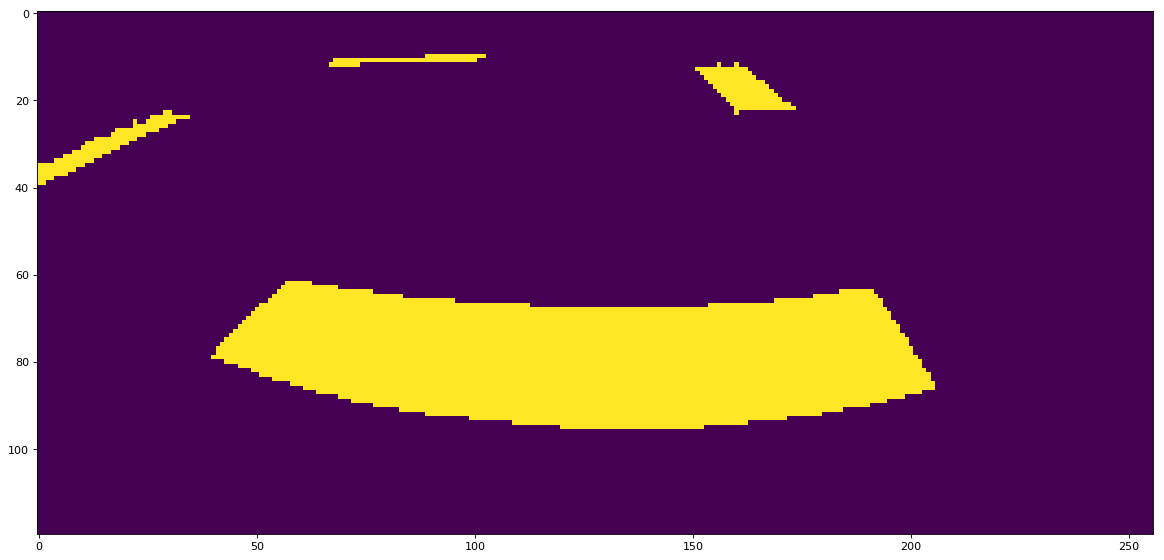

256 120


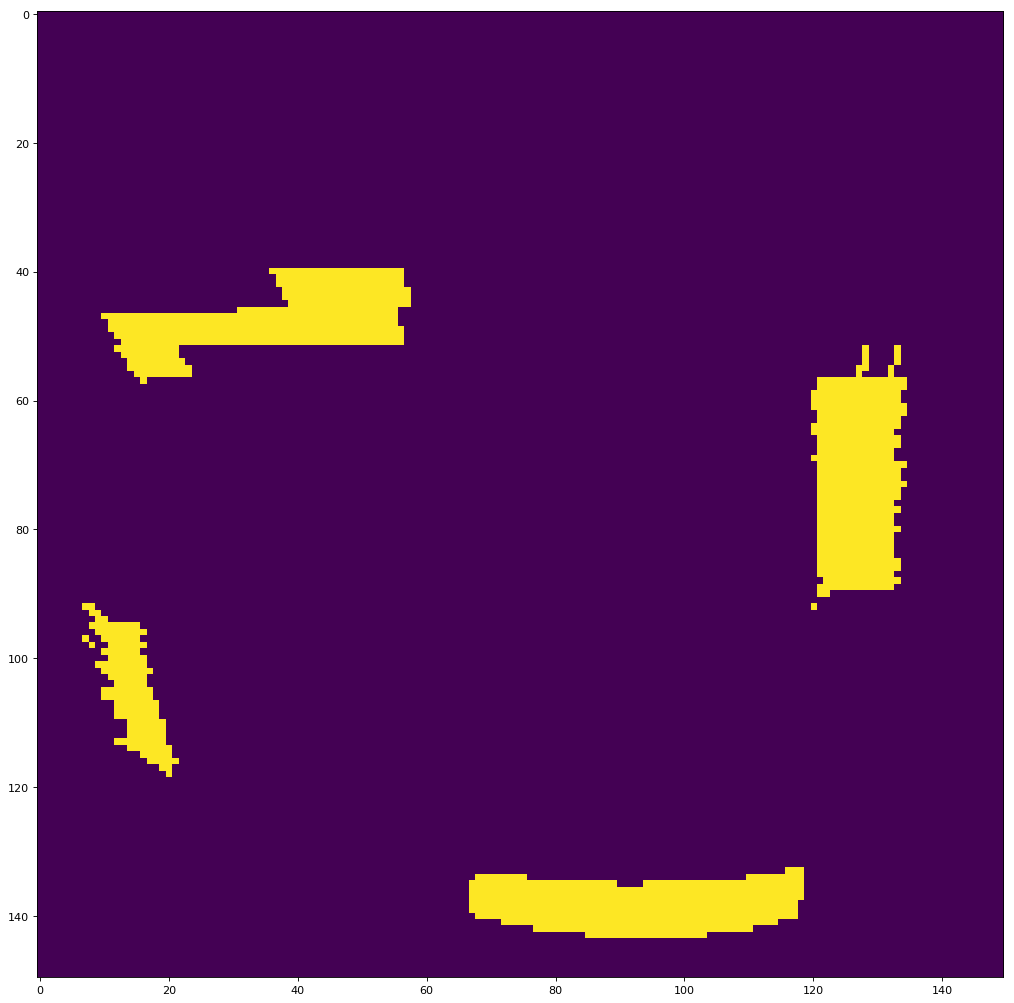

In [232]:
# Each tile is 61 cm long, I want to see a tile's worth projected.
# Centered in front of the robot
x_r = np.array([0.123, 0.123+0.61])
y_r = np.array([-30.5, 30.5])

# origin: (x,y) in m coordinates of the near-left corner of the square
# side:   side in m of square on the ground 
# w:    side in pixels of the output image
def ground_project(image, origin, side, w):
    # H assumes incoming image resolution is VGA (640x480) use output_scale to fix
    # pixel at bottom center is x: 0.128 y: 0.00344677851347
    # x axis is longitudinal, y axis is to the left
    # bottom edge aligned
    x = np.linspace(origin[0]+side, origin[0], w)
    y = np.linspace(origin[1], origin[1]+side, w)
    dy,dx = np.meshgrid(y,x)
    grid = np.stack((dx,-dy) ,axis=-1)
    
    output = np.zeros((w, w))
    
    oh, ow = np.shape(image) #original width, original height
    print(ow,oh)
    for row in range(w):
        for column in range(w):
            x,y = grid[row,column]
            p = Point(x,y,0)
            pix = ground2pixel(p)
            pix.v -= cutoff
            pix.v *= output_scale
            pix.u *= output_scale
            if pix.v < oh and pix.v >= 0 and pix.u < ow and pix.u >= 0:
                output[row,column] = image[int(pix.v), int(pix.u)]
            else:
                output[row,column] = 0
    return output

image = reds[0].patches
imshow(image)
#square = ground_project(image, [0.123, -0.305], 0.6, 100)
square = ground_project(image, [0.123, -0.45], 0.7, 150)
imshow(square)

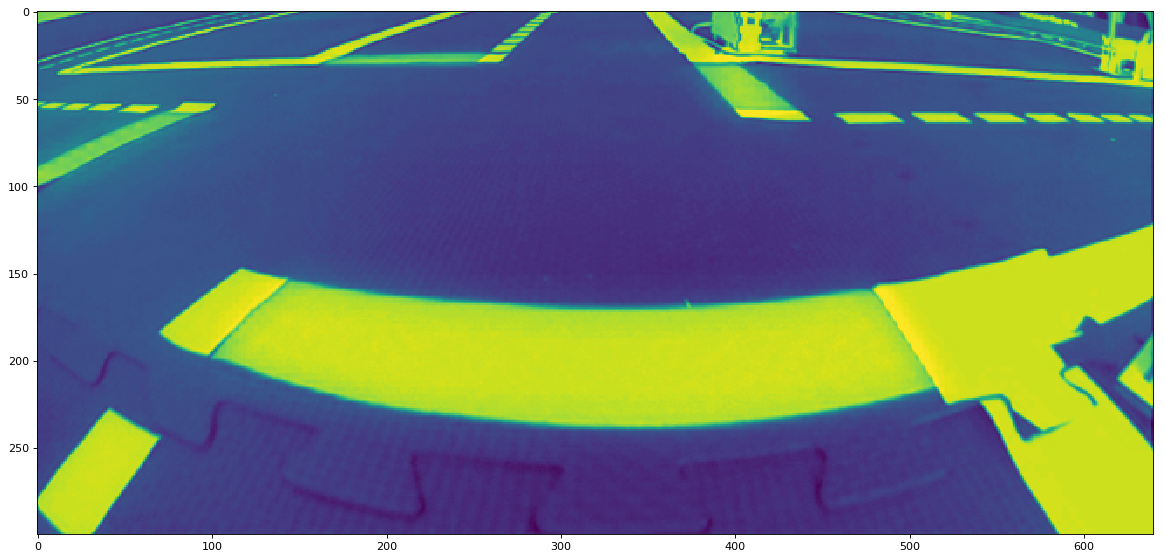

In [211]:
imshow(compressed[0][:,:,2])

x: 0.738
y: 0.003
z: 0.0
u: 130.34374123
v: 7.14664784185
[218 220 221]


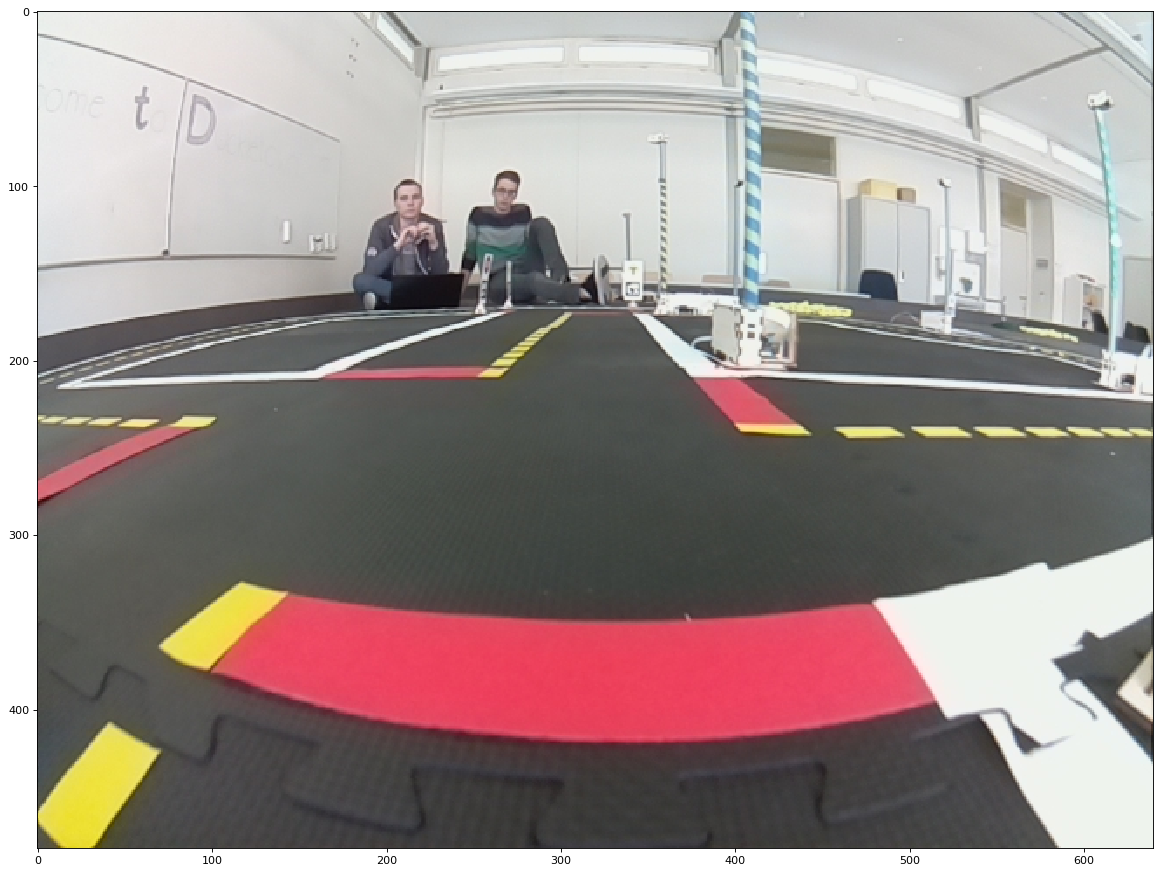

In [186]:
p = Pixel()
p.u = 640#327
p.v = 480#330 + cutoff
gnd = pixel2ground(p)

gnd.x = 0.128+0.61
gnd.y = 0.003
# v stands for vertical
pix = ground2pixel(gnd)
pix.v -= cutoff
pix.u *= output_scale
pix.v *= output_scale
print(gnd)
print(pix)
print(image[int(pix.v),int(pix.u)])
bgrshow(image)

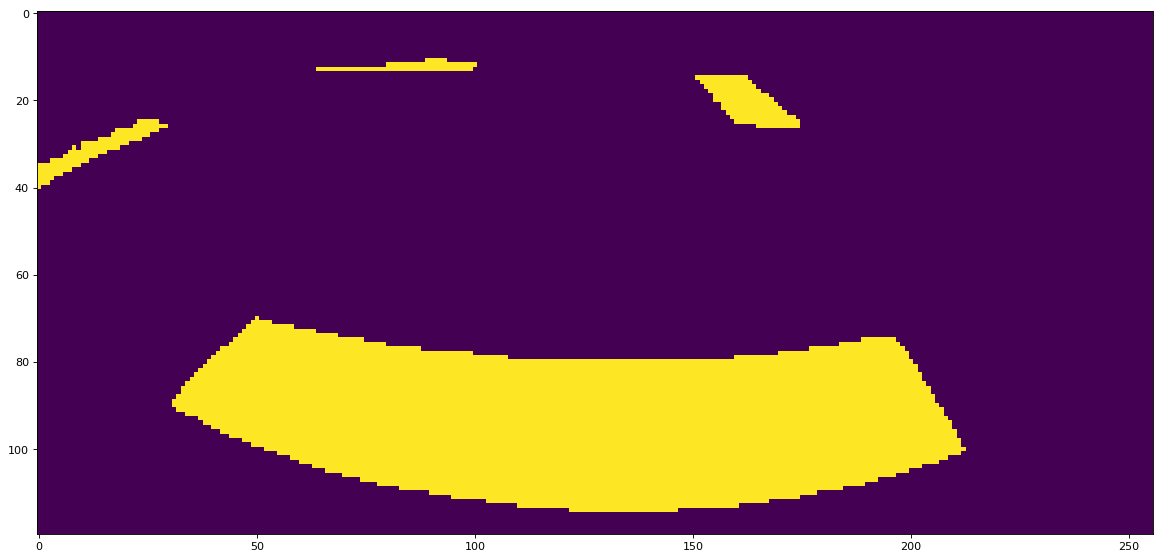

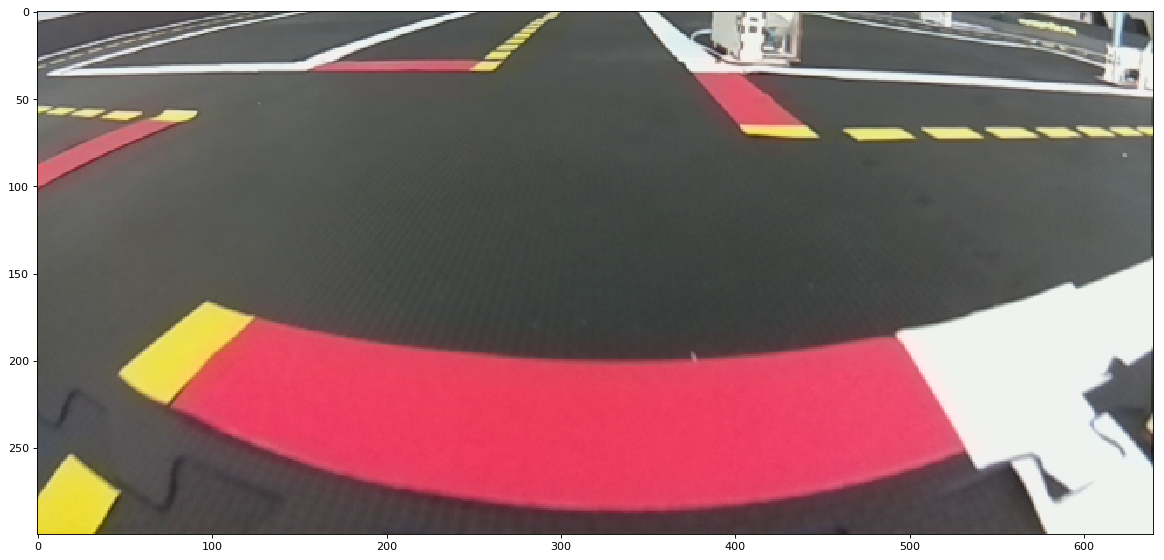

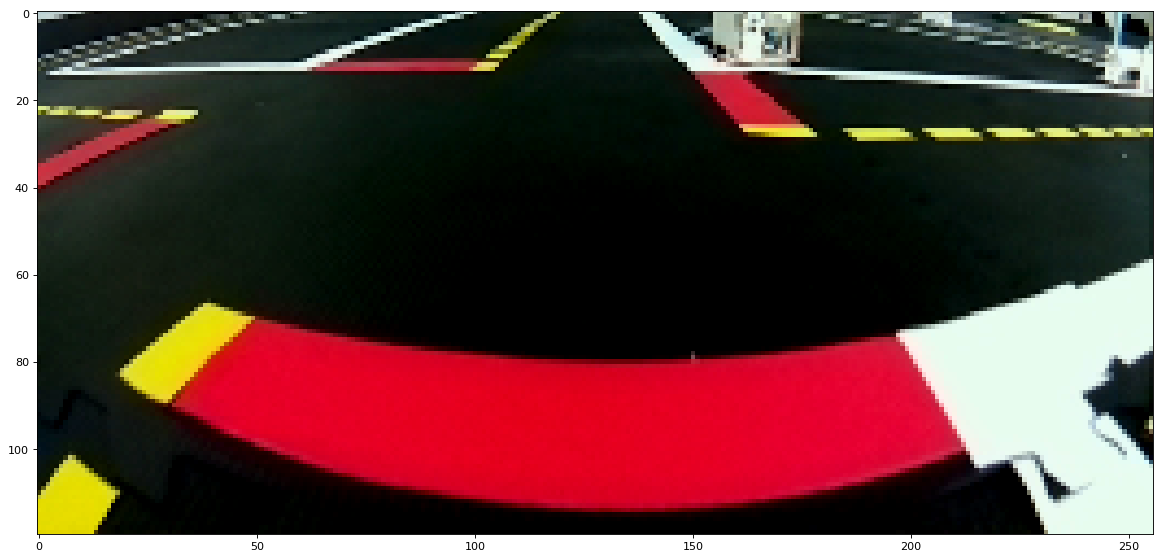

In [130]:
test = compressed[1]
red = reds[1].patches
imshow(red)
bgrshow(test)
bgrshow(ai.apply_color_balance(test, output_scale))

In [97]:
# PROCESS ALL IMAGES AND STORE THEM IN ARRAYS
compressed = []
cutoff = 180
raw = []
for im_path in sorted(glob.glob("frames/*.png")):
    bgr = cv2.imread(im_path,cv2.IMREAD_COLOR)
    raw.append(bgr)
    compressed.append(bgr[cutoff:,:,:])

antiig = []
reds = []
output_scale = 0.4
color_balance_percentage = 0.8
ai = AntiInstagram()

if len(compressed)>0:
    ai.calculate_color_balance_thresholds(compressed[0], output_scale, color_balance_percentage)
    print("setup AI filter")
    
for img in compressed:
    reds.append(process(img))
    
print("Filtered "+str(len(reds))+" images")

setup AI filter
Filtered 30 images
